In [29]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import requests
import hvplot.pandas

from pprint import pprint

# Import API key
from config import geoapify_key

In [30]:
#Import CSV
df = pd.read_csv("output/offences_dates.csv", index_col=0)
df.dropna(how='any', inplace=True)
df.head()


,Reported Date,Suburb - Incident,Postcode - Incident,Offence Level 1 Description,Offence Level 2 Description,Offence Level 3 Description,Offence count,Month,Year
0,2013-07-01,ADELAIDE,5000,OFFENCES AGAINST THE PERSON,ACTS INTENDED TO CAUSE INJURY,Common Assault,2,7,2013
1,2013-07-01,ALDINGA BEACH,5173,OFFENCES AGAINST THE PERSON,ACTS INTENDED TO CAUSE INJURY,Common Assault,1,7,2013
2,2013-07-01,ALDINGA BEACH,5173,OFFENCES AGAINST THE PERSON,ACTS INTENDED TO CAUSE INJURY,Serious Assault not resulting in injury,1,7,2013
3,2013-07-01,BEDFORD PARK,5042,OFFENCES AGAINST THE PERSON,ROBBERY AND RELATED OFFENCES,Blackmail and extortion,1,7,2013
4,2013-07-01,BURTON,5110,OFFENCES AGAINST THE PERSON,OTHER OFFENCES AGAINST THE PERSON,Threatening behaviour,1,7,2013


In [31]:
print(df['Offence Level 2 Description'].unique())


['ACTS INTENDED TO CAUSE INJURY' 'ROBBERY AND RELATED OFFENCES'
 'OTHER OFFENCES AGAINST THE PERSON' 'SEXUAL ASSAULT AND RELATED OFFENCES'
 'HOMICIDE AND RELATED OFFENCES']


In [32]:
print(df['Offence Level 3 Description'].unique())

['Common Assault' 'Serious Assault not resulting in injury'
 'Blackmail and extortion' 'Threatening behaviour' 'Assault police'
 'Abduction, harassment and other offences'
 'Other acts intended to cause injury'
 'Serious Assault resulting in injury' 'Aggravated sexual assault'
 'Non-aggravated sexual assault' 'Non-assaultive sexual offences'
 'Dangerous or negligent acts' 'Aggravated robbery'
 'Non-aggravated robbery' 'Other homicide and related offences' 'Murder']


In [33]:
# Select the 'Suburb - Incident' and 'Postcode - Incident' columns
suburb_postcode_df = df[['Suburb - Incident', 'Postcode - Incident']]

# Drop duplicate rows
unique_suburb_postcode_df = suburb_postcode_df.drop_duplicates()
#Drop duplicate postcodes, just keeping one suburb for each postcode
unique_suburb_postcode_df = unique_suburb_postcode_df.groupby('Postcode - Incident').first().reset_index()
#Add columns for Latitude and Longitude
unique_suburb_postcode_df['Latitude'] = ""
unique_suburb_postcode_df['Longitude'] = ""

unique_suburb_postcode_df.head()

,Postcode - Incident,Suburb - Incident,Latitude,Longitude
0,0872,PUKATJA,,
1,2010,DARLINGHURST,,
2,2148,MARAYONG,,
3,2250,SPRINGFIELD,,
4,2330,SINGLETON,,


In [34]:
#get Latitude and Longitude for each postcode via loop

# Create empty lists to store latitude and longitude values
latitude_list = []
longitude_list = []

# Iterate over each row in the DataFrame
for index, row in unique_suburb_postcode_df.iterrows():
    # Fetch suburb and postcode from the row
    suburb = row['Suburb - Incident']
    postcode = row['Postcode - Incident']
    
    # Make a request to Geoapify Geocoding API
    url = f"https://api.geoapify.com/v1/geocode/search?postcode={postcode}&country=Australia&text={suburb}&state=South%20Australia&apiKey={geoapify_key}"
    response = requests.get(url).json()
    pprint(response)

    if 'features' in response and len(response['features']) > 0:
        #Get the Latitude and Longitude
        latitude = response['features'][0]['properties']['lat']
        longitude = response['features'][0]['properties']['lon']
    else:
        latitude, longitude = None, None    
    
    # Append latitude and longitude to the respective lists
    latitude_list.append(latitude)
    longitude_list.append(longitude)
    
# Add latitude and longitude columns to the DataFrame
unique_suburb_postcode_df['Latitude'] = latitude_list
unique_suburb_postcode_df['Longitude'] = longitude_list

# Print the updated DataFrame
unique_suburb_postcode_df.head()

{'features': [{'bbox': [132.0977062, -26.3334536, 132.1890019, -26.2562562],
               'geometry': {'coordinates': [132.1338209, -26.2766919],
                            'type': 'Point'},
               'properties': {'address_line1': 'Pukatja SA 0872',
                              'address_line2': 'Australia',
                              'category': 'administrative',
                              'city': 'Pukatja',
                              'country': 'Australia',
                              'country_code': 'au',
                              'county': 'Anangu Pitjantjatjara Yankunytjatjara',
                              'datasource': {'attribution': '© OpenStreetMap '
                                                            'contributors',
                                             'license': 'Open Database License',
                                             'sourcename': 'openstreetmap',
                                             'url': 'https://www.openstr

,Postcode - Incident,Suburb - Incident,Latitude,Longitude
0,0872,PUKATJA,-26.276692,132.133821
1,2010,DARLINGHURST,-33.878338,151.219225
2,2148,MARAYONG,-33.749167,150.891944
3,2250,SPRINGFIELD,-33.314841,151.218226
4,2330,SINGLETON,-32.695366,151.022209


In [35]:
unique_suburb_postcode_df.head()

,Postcode - Incident,Suburb - Incident,Latitude,Longitude
0,0872,PUKATJA,-26.276692,132.133821
1,2010,DARLINGHURST,-33.878338,151.219225
2,2148,MARAYONG,-33.749167,150.891944
3,2250,SPRINGFIELD,-33.314841,151.218226
4,2330,SINGLETON,-32.695366,151.022209


In [36]:
# Group the DataFrame by 'Postcode - Incident' and aggregate the 'Suburb - Incident' column
# Group the DataFrame by 'Postcode - Incident' and aggregate the 'Suburb - Incident' and 'Offence count' columns
post_sub = df.groupby('Postcode - Incident').agg({'Suburb - Incident': lambda x: ', '.join(set(x)), 'Offence count': 'sum'}).reset_index()

# Rename the aggregated columns
post_sub.rename(columns={'Suburb - Incident': 'Suburbs', 'Offence count': 'Total Incident Count'}, inplace=True)
# Print the new DataFrame
print(post_sub)

    Postcode - Incident                                            Suburbs  \
0                  0872  KANPI, DE ROSE HILL, PIPALYATJARA, IWANTJA, MI...   
1                  2010                                       DARLINGHURST   
2                  2148                                           MARAYONG   
3                  2250                                        SPRINGFIELD   
4                  2330                                          SINGLETON   
..                  ...                                                ...   
353                5960                      GARDEN ISLAND, TORRENS ISLAND   
354                6330                                         TORNDIRRUP   
355                6440                                            JAMESON   
356                 872  KANPI, PIPALYATJARA, PETERMANN, IWANTJA, MIMIL...   
357       NOT DISCLOSED                                      NOT DISCLOSED   

     Total Incident Count  
0                     838  
1      

In [37]:
merged_latlon = pd.merge(post_sub, unique_suburb_postcode_df, on='Postcode - Incident' )
# Convert 'Latitude' column to numeric and coerce non-numeric values to NaN
merged_latlon['Latitude'] = pd.to_numeric(merged_latlon['Latitude'], errors='coerce')

# Drop rows where 'Latitude' is NaN
merged_latlon = merged_latlon.dropna(subset=['Latitude'])
merged_latlon.head()

#Drop rows with <5 incidents.
merged_latlon = merged_latlon[merged_latlon['Total Incident Count'] > 5]

merged_latlon.head()


,Postcode - Incident,Suburbs,Total Incident Count,Suburb - Incident,Latitude,Longitude
0,0872,"KANPI, DE ROSE HILL, PIPALYATJARA, IWANTJA, MI...",838,PUKATJA,-26.276692,132.133821
15,5000,"ADELAIDE, MILE END, UNLEY",14578,ADELAIDE,-34.928181,138.599931
16,5006,NORTH ADELAIDE,922,NORTH ADELAIDE,-34.908501,138.595350
17,5007,"WELLAND, WEST HINDMARSH, BOWDEN, HINDMARSH, BR...",1204,BOWDEN,-34.902896,138.579979
18,5008,"RENOWN PARK, DUDLEY PARK, CROYDON, DEVON PARK,...",1597,CROYDON PARK,-34.880250,138.567491


In [38]:
%%capture --no-display

# Configure the map
plot = merged_latlon.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "CartoDark",
    frame_width = 1200,
    frame_height = 1000,
    size = "Total Incident Count",
    scale = 0.3,
    color = "Total Incident Count",
    hover_cols = ['Suburbs', 'Postcode - Incident'],
    color_key='rainbow'
)

# Display the map plot
plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Total Incident Count,Suburbs,Postcode - Incident)

In [39]:
#Work out top 5 total crimes
highest_incidents = merged_latlon.sort_values(by='Total Incident Count', ascending=False).head(5)
high_incident_postcodes = highest_incidents['Postcode - Incident'].tolist()
high_incident_postcodes


['5000', '5108', '5112', '5113', '5700']

In [40]:
#I'm sure there is a better way, but... create seperate DF for each of the top 5 postcodes.
df_5000 = df[df['Postcode - Incident'].isin([high_incident_postcodes[0]])]
df_5108 = df[df['Postcode - Incident'].isin([high_incident_postcodes[1]])]
df_5112 = df[df['Postcode - Incident'].isin([high_incident_postcodes[2]])]
df_5113 = df[df['Postcode - Incident'].isin([high_incident_postcodes[3]])]
df_5700 = df[df['Postcode - Incident'].isin([high_incident_postcodes[4]])]

In [41]:
df_5000_grouped = df_5000.groupby(['Offence Level 3 Description', 'Year']).agg({'Offence count': 'sum'}).reset_index()
df_5000_grouped.head()

,Offence Level 3 Description,Year,Offence count
0,"Abduction, harassment and other offences",2013,26
1,"Abduction, harassment and other offences",2014,64
2,"Abduction, harassment and other offences",2015,68
3,"Abduction, harassment and other offences",2016,59
4,"Abduction, harassment and other offences",2017,59


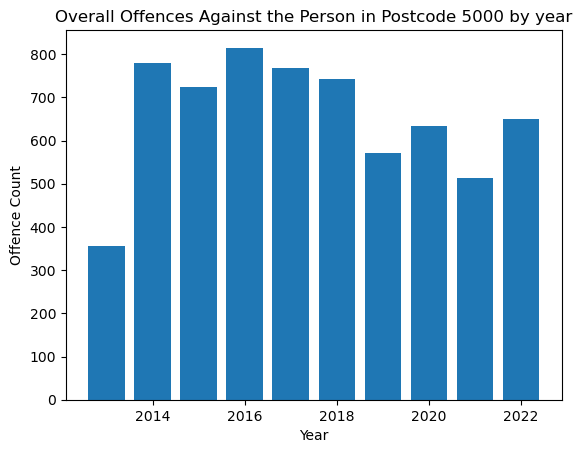

In [42]:
#Create plot for total crimes yoy
#plot
plt.bar(df_5000_grouped['Year'], df_5000_grouped['Offence count'])
#Details
plt.xlabel('Year')
plt.ylabel('Offence Count')
plt.title(f'Overall Offences Against the Person in Postcode 5000 by year')
#Show the plot

plt.show()

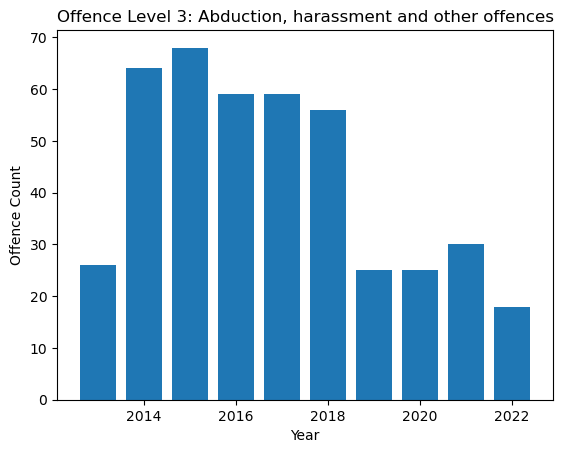

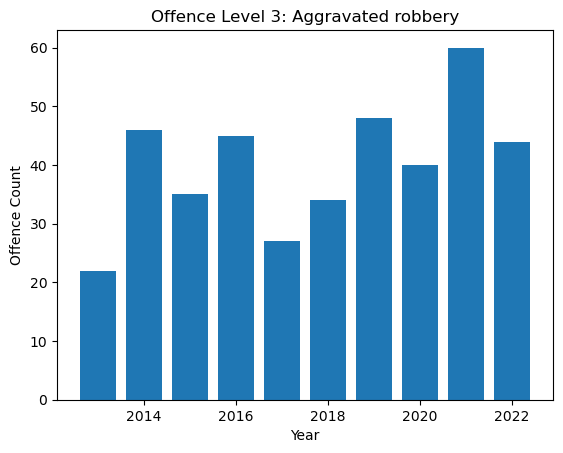

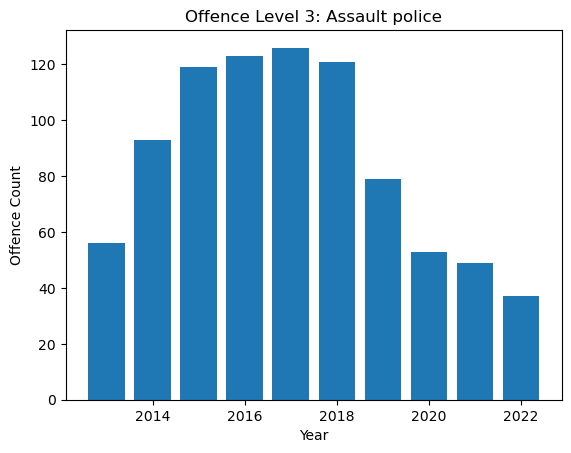

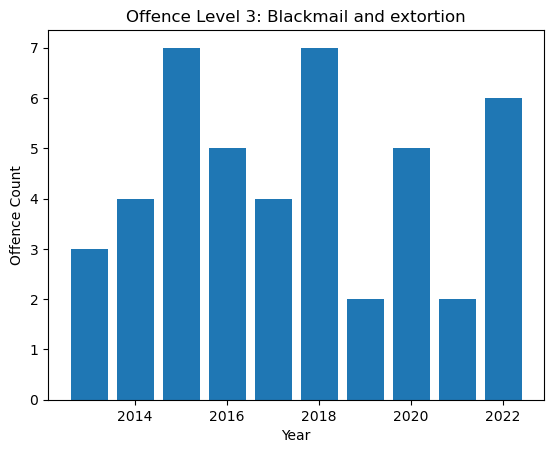

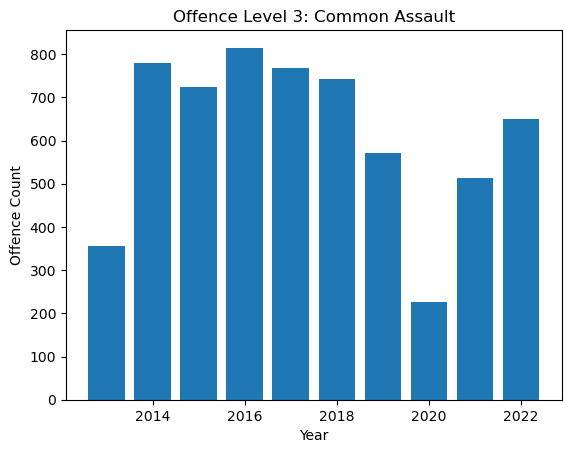

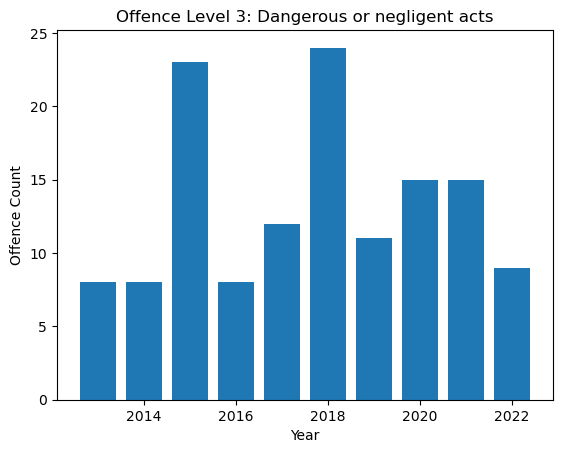

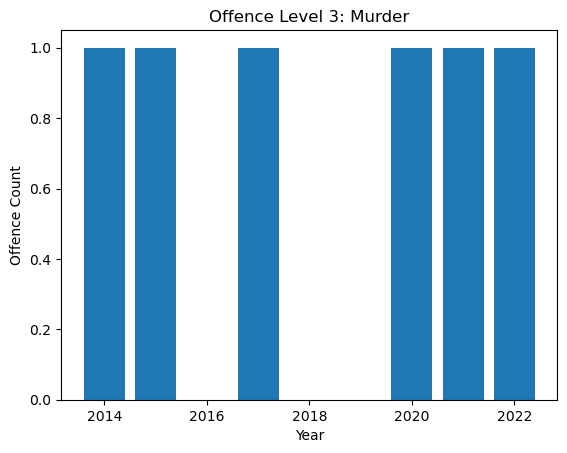

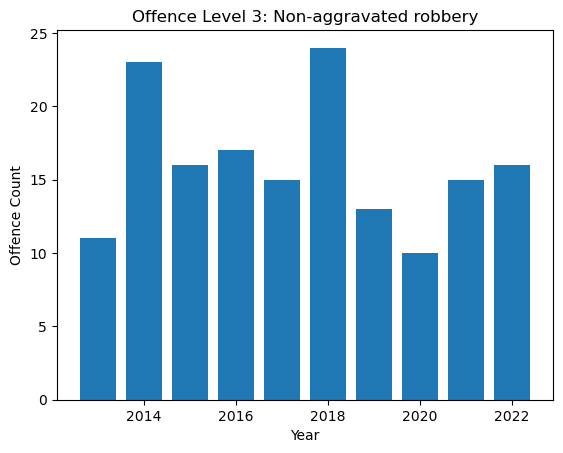

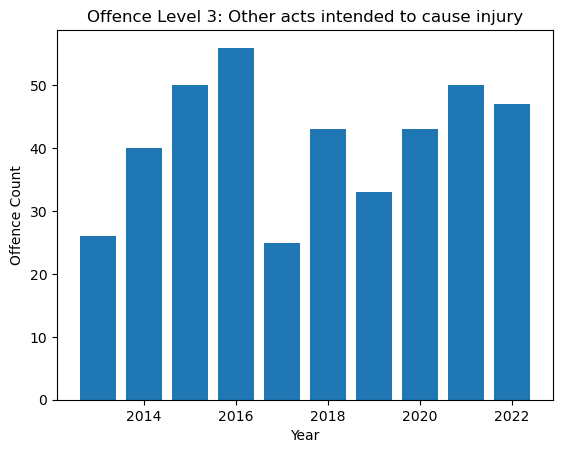

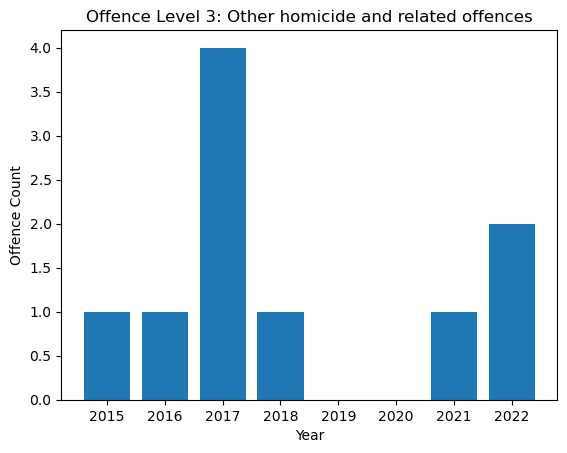

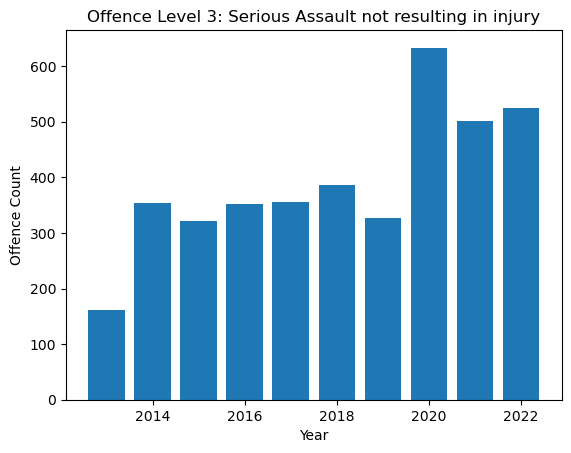

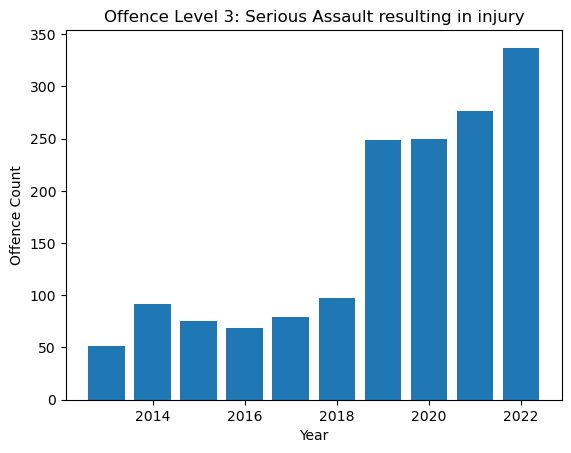

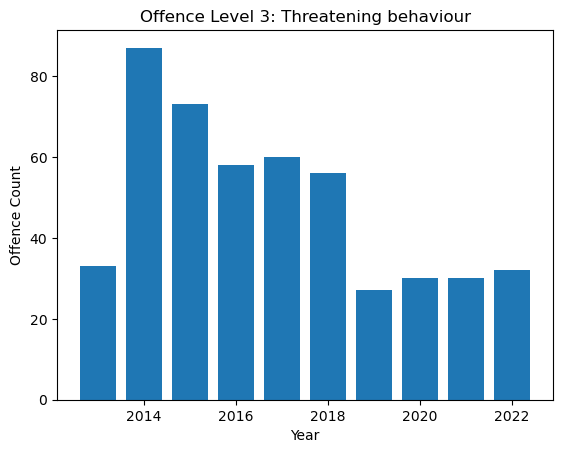

In [43]:
# Create a separate plot for each Offence Level 3 category
offence_categories = df_5000_grouped['Offence Level 3 Description'].unique()

#iterate over categories
for category in offence_categories:
    #subset data for each category
    data = df_5000_grouped[df_5000_grouped['Offence Level 3 Description'] == category]
    #creates a new figure
    plt.figure()
    #plot
    plt.bar(data['Year'], data['Offence count'])
    #Details
    plt.xlabel('Year')
    plt.ylabel('Offence Count')
    plt.title(f'Offence Level 3: {category}')
#Show the plot
plt.show()